In [21]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from sklearn.metrics import classification_report
from src.utils import (plot_confusion_matrix, 
                        line_label_id2label, 
                        line_Label_label2id, 
                        performance_metrics, 
                        plot_embeddings, 
                        get_df_classificationreport)

import pandas as pd

import torch

# MedBERT Finetune on Lines

In [15]:
results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_test.pt")
labels = results["labels"]
last_hidden_state = results["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
preds = results["preds"]

In [3]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

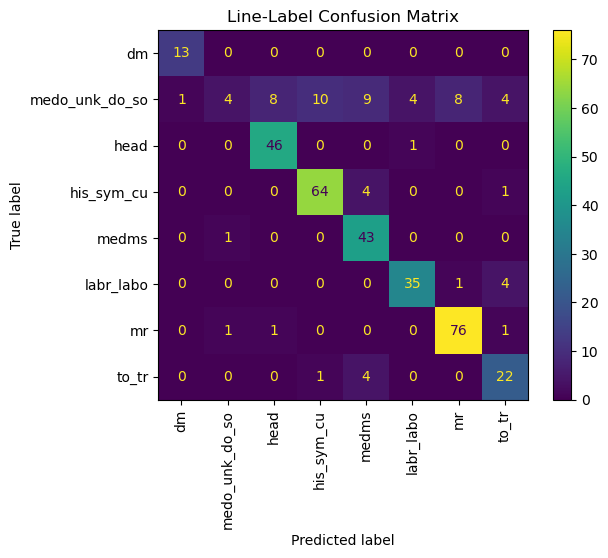

In [4]:
plot_confusion_matrix(preds=preds, labels=labels, title="Line-Label Confusion Matrix", label2id=line_Label_label2id)

In [5]:
y_valid = [line_label_id2label[label] for label in labels]
y_pred = [line_label_id2label[pred] for pred in preds]
get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.84,0.98,0.90,47
2,his_sym_cu,0.85,0.93,0.89,69
3,labr_labo,0.88,0.88,0.88,40
4,medms,0.72,0.98,0.83,44
5,medo_unk_do_so,0.67,0.08,0.15,48
6,mr,0.89,0.96,0.93,79
7,to_tr,0.69,0.81,0.75,27
8,accuracy,NaN,NaN,0.83,367
9,macro avg,0.81,0.83,0.78,367


(367, 2)


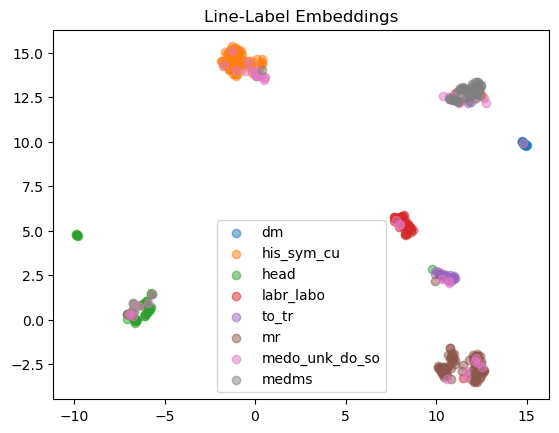

In [6]:
plot_embeddings(embeddings, [line_label_id2label[label] for label in labels], title="Line-Label Embeddings", method="umap", )

In [23]:
# Analysis of FP and TP
# results.pop("last_hidden_state")
# results_df = pd.DataFrame(results)
results_df.replace(line_label_id2label, inplace = True)

In [24]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)
results_df[results_df["preds"] != results_df["labels"]]

,preds,labels,rid,text
8,medms,medo_unk_do_so,3A79B7BD-39B6-4AE5-82C5-ADAB09B34A41,INDENT - OCTiMS-Studie
16,head,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,Allgemeine Diagnosen
17,dm,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,Sekundär-chronisch progrediente (seit ca. 2008) Multiple Sklerose (ES und ED 1995); EDSS 6.0
18,head,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,INDENT Klinisch:
19,his_sym_cu,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,"INDENT Verschlechterung der Gehfähigkeit seit 9/11, seit 11/11 Gehstock, aktuell Rollator"
20,his_sym_cu,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,"INDENT spastisch-ataktisches Gangbild, Feinmotorikstörung, neurogene Blasenstörung, Kopftremor"
21,his_sym_cu,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,"INDENT Fatigue, leichte bis mittelschwere kognitive Defizite"
22,head,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,INDENT Verlauf:
23,mr,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,"INDENT EDSS Verlauf: 10/2005 2.0, 9/2006 2.0, 11/2007 2.5, 2/2009 2.5, 9/2009 3.0, 11/2010 4.5, 10/2011 5.5 , seit 11/2011 6.0"
24,his_sym_cu,medo_unk_do_so,132AFE10-1DF9-41FF-B68F-2A94D8B75A98,"INDENT 12/2008 Schub mit Beinschmerzen, Gehschwierigkeiten"


In [25]:
results_df[results_df["labels"] == "head"]

,preds,labels,rid,text
3,head,head,3A79B7BD-39B6-4AE5-82C5-ADAB09B34A41,Diagnostisch:
9,head,head,3A79B7BD-39B6-4AE5-82C5-ADAB09B34A41,Therapeutisch:
47,head,head,146E4473-897F-402D-9F33-7943658FB47D,Aktuell:
52,head,head,146E4473-897F-402D-9F33-7943658FB47D,Verlauf:
60,head,head,146E4473-897F-402D-9F33-7943658FB47D,Diagnostisch:
81,head,head,146E4473-897F-402D-9F33-7943658FB47D,therapeutisch:
89,head,head,0DE495A9-654A-4D91-B881-F9A97907ADD2,Verlauf:
93,head,head,0DE495A9-654A-4D91-B881-F9A97907ADD2,diagnostisch:
103,head,head,0DE495A9-654A-4D91-B881-F9A97907ADD2,therapeutisch:
110,head,head,1BBB3840-9274-4DA4-83BF-36D6D5AFF986,Verlauf:


# MedBERT Token Classification

In [29]:
results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test.pt")

In [30]:
labels, preds = [], []
for obs in results:
    labels.extend(obs["labs"])
    preds.extend(obs["preds"])

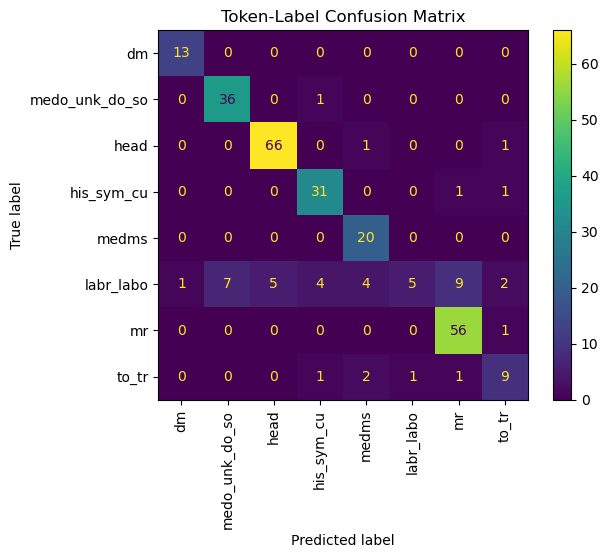

In [31]:
plot_confusion_matrix(preds=preds, labels=labels, title="Token-Label Confusion Matrix", label2id=line_Label_label2id)

In [33]:
get_df_classificationreport(labels, preds, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.84,0.97,0.90,37
2,his_sym_cu,0.93,0.97,0.95,68
3,labr_labo,0.84,0.94,0.89,33
4,medms,0.74,1.00,0.85,20
5,medo_unk_do_so,0.83,0.14,0.23,37
6,mr,0.84,0.98,0.90,57
7,to_tr,0.64,0.64,0.64,14
8,accuracy,NaN,NaN,0.85,279
9,macro avg,0.82,0.83,0.79,279
